In [47]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings("ignore")

from surprise import SVD, KNNWithMeans
from surprise import Dataset, Reader

In [2]:
data = pd.read_csv('data/AMAZON_FASHION.csv', names=['item', 'user', 'rating', 'timestamp'])

In [4]:
print(data.shape)
data.head()

(883636, 4)


,item,user,rating,timestamp
0,7106116521,A1D4G1SNUZWQOT,5.0,1413763200
1,7106116521,A3DDWDH9PX2YX2,2.0,1411862400
2,7106116521,A2MWC41EW7XL15,4.0,1408924800
3,7106116521,A2UH2QQ275NV45,2.0,1408838400
4,7106116521,A89F3LQADZBS5,3.0,1406419200


In [5]:
users = data['user'].unique()
items = data['item'].unique()

user_to_id = {x: i for i, x in enumerate(users)}
item_to_id = {x: i for i, x in enumerate(items)}

id_to_user = {i: x for i, x in enumerate(users)}
id_to_item = {i: x for i, x in enumerate(items)}

In [6]:
data['item'] = data['item'].map(item_to_id)
data['user'] = data['user'].map(user_to_id)

#### Короткое EDA

In [7]:
# Кол-во item user
data.item.nunique(), data.user.nunique()

(186189, 749233)

In [8]:
# Средняя оценка
data['rating'].mean()

3.9069401880412298

<AxesSubplot:>

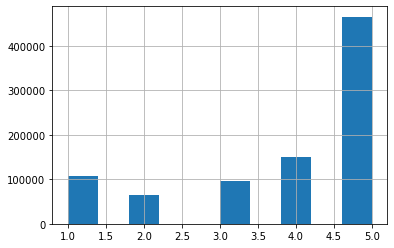

In [9]:
# Распределение оценок
data['rating'].hist()

In [10]:
# Топ10 самых часто оцениваемых товаров
data['item'].value_counts()[:10]

177     4384
115     4375
3190    3889
5891    3638
142     2572
208     2538
383     2206
2906    2027
140     1928
7065    1855
Name: item, dtype: int64

In [11]:
# Товары у которых больше всего 5рок
data[data['rating'] == 5]['item'].value_counts()[:10]

5891    3257
177     3229
115     3224
3190    2792
142     1991
7065    1559
383     1464
140     1274
2906    1210
259     1176
Name: item, dtype: int64

In [13]:
# Топ самых хороших и плохих товаров по оценкам.

tmp = data['item'].value_counts() > 300
tmp_items = tmp[tmp == True].index

display(data[data['item'].isin(tmp_items)].groupby(['item'])['rating'].mean().sort_values(ascending=False)[:10])

display(data[data['item'].isin(tmp_items)].groupby(['item'])['rating'].mean().sort_values(ascending=False)[-10:])

item
10246    4.844991
1965     4.827411
5891     4.826003
2705     4.807453
448      4.793103
382      4.770624
511      4.739496
7065     4.727224
2057     4.698413
10497    4.676380
Name: rating, dtype: float64

item
1630     3.231602
3593     3.146040
6417     3.004902
6136     2.987080
1849     2.949843
7578     2.933131
2928     2.933131
9054     2.915811
6044     2.798403
11233    2.723485
Name: rating, dtype: float64

#### Разбиваем на train/test, будем использовать библиотеку surprise. Будем предсказывать рейтинг, метрика RMSE.

In [18]:
data_sorted = data.sort_values(by='timestamp')

In [23]:
cut_off = int(data.shape[0] * 0.8)

train = data_sorted[:cut_off]
test = data_sorted[cut_off:]

In [25]:
# Вначале SVD разлоежение

reader = Reader(rating_scale=(1, 5))
train_set = Dataset.load_from_df(train[['user', 'item', 'rating']], reader)
trainset = train_set.build_full_trainset()

algo = SVD(n_factors=50, n_epochs=40)

algo.fit(trainset)

In [33]:
pred = np.zeros(test.shape[0])
for i, tupl in enumerate(test.itertuples()):
    pred[i] = algo.predict(tupl.user, tupl.item).est

test['pred'] = pred

In [36]:
def normilize_pred(x):
    if x < 1:
        return 1
    elif x > 5:
        return 5
    return x

test['pred'] = test['pred'].apply(normilize_pred)

In [46]:
from sklearn.metrics import mean_squared_error

metric = mean_squared_error(test['rating'], test['pred'], squared=False)
print(f'RMSE on test sample = {round(metric, 3)}')

RMSE on test sample = 1.347
